In [1]:
# !pip install split-folders

In [2]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os

plt.style.use('classic')

import optuna                  #bibliotecas para otimização
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.models import Sequential


from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from keras.utils import normalize, to_categorical
from keras.layers import Dropout
from keras.optimizers import SGD, RMSprop

import splitfolders  #separar treino, test e validacao

2025-11-16 18:26:33.735998: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-16 18:26:33.801807: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-16 18:26:36.239832: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


In [3]:
import splitfolders

input_folder = "preprocessamento"   # nome da pasta onde estão as 3 classes
output_folder = "dataset_separado" 

splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=7123,
    ratio=(0.8, 0.05, 0.15),  # treino, validação, teste
)


Copying files: 1322 files [01:02, 21.15 files/s]


In [4]:
train_dir = "dataset_separado/train"
val_dir   = "dataset_separado/val"
test_dir  = "dataset_separado/test"

img_size = (128,128)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    label_mode="int",
    image_size=img_size,
    batch_size=batch_size,
    seed=710
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dir,
    label_mode="int",
    image_size=img_size,
    batch_size=batch_size,
    seed=710
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode="int",
    image_size=img_size,
    batch_size=batch_size,
    seed=710
)


# Mostrar classes detectadas
class_names = train_ds.class_names
print("Classes detectadas:", class_names)

# "X" e "y" equivalentes
X_train, y_train = [], []
for batch_x, batch_y in train_ds:
    X_train.append(batch_x)
    y_train.append(batch_y)

X_test, y_test = [], []
for batch_x, batch_y in test_ds:
    X_test.append(batch_x)
    y_test.append(batch_y)

# Converter listas para tensores grandes (opcional)
X_train = tf.concat(X_train, axis=0)
y_train = tf.concat(y_train, axis=0)
X_test  = tf.concat(X_test, axis=0)
y_test  = tf.concat(y_test, axis=0)

print("The size of training dataset X is:", X_train.shape)
print("The size of testing dataset X is:", X_test.shape)

print("The size of training dataset y is:", y_train.shape)
print("The size of testing dataset y is:", y_test.shape)


Found 1057 files belonging to 3 classes.


2025-11-16 18:27:39.959888: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Found 64 files belonging to 3 classes.
Found 201 files belonging to 3 classes.
Classes detectadas: ['Healthy_preprocessada', 'Powdery_preprocessada', 'Rust_preprocessada']


2025-11-16 18:28:23.230273: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The size of training dataset X is: (1057, 128, 128, 3)
The size of testing dataset X is: (201, 128, 128, 3)
The size of training dataset y is: (1057,)
The size of testing dataset y is: (201,)


2025-11-16 18:28:32.349416: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
X_train = X_train.numpy()
X_test = X_test.numpy()


In [6]:
X_train = (X_train.astype('float32')) / 255.
X_test = (X_test.astype('float32')) / 255.


In [7]:
def instancia_modelo(trial):

    # Hiperparâmetros sugeridos pelo Optuna
    parametros = {
        "kernel_initializer": trial.suggest_categorical(
            "kernel_initializer", ["he_uniform", "random_uniform"]
        ),
        "activation": trial.suggest_categorical(
            "activation", ["relu", "tanh"]
        ),
        "dropout_rate": trial.suggest_float(
            "dropout", 0.1, 0.5
        ),
        "learning_rate": trial.suggest_float(
            "lr", 1e-4, 1e-2, log=True
        ),
        "n_jobs": -1
    }

    # Acessando os valores
    kernel_initializer = parametros["kernel_initializer"]
    activation = parametros["activation"]
    dropout_rate = parametros["dropout_rate"]
    lr = parametros["learning_rate"]

    # NÚMERO DE FILTROS
    filters1 = trial.suggest_categorical("filters1", [16, 32, 64])
    filters2 = trial.suggest_categorical("filters2", [32, 64, 128])

    # MODELO
    model = Sequential([
        tf.keras.layers.Rescaling(1./255, input_shape=(128,128,3)),

        Conv2D(filters1, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
        MaxPooling2D((2,2)),
        Dropout(dropout_rate),

        Conv2D(filters2, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
        MaxPooling2D((2,2)),
        Dropout(dropout_rate),

        Flatten(),
        Dense(256, activation=activation, kernel_initializer=kernel_initializer),

        Dense(3, activation='softmax')
    ])

    # Otimizador (importante!)
    optimizer = SGD(learning_rate=lr, momentum=0.9)

    model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model


In [8]:
def funcao_objetivo(trial):

    model = instancia_modelo(trial)

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=5,
        batch_size=32,
        verbose=0
    )

    val_acc = history.history["val_accuracy"][-1]

    return val_acc

In [9]:
study = optuna.create_study(
    direction="maximize",
    study_name="CNN_comproc__optuna",
    storage="sqlite:///cnn_optuna.db",
    load_if_exists=True
)

study.optimize(funcao_objetivo, n_trials=50)


[I 2025-11-16 18:28:33,138] A new study created in RDB with name: CNN_comproc__optuna
/home/lorena24014/anaconda3/envs/img_proc/lib/python3.10/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2025-11-16 18:30:49,399] Trial 0 finished with value: 0.3396226465702057 and parameters: {'kernel_initializer': 'he_uniform', 'activation': 'tanh', 'dropout': 0.31712888735243105, 'lr': 0.00023895497002426042, 'filters1': 64, 'filters2': 128}. Best is trial 0 with value: 0.3396226465702057.
[I 2025-11-16 18:31:19,964] Trial 1 finished with value: 0.3396226465702057 and parameters: {'kernel_initializer': 'he_uniform', 'activation': 'relu', 'dropout': 0.17822827143764935, 'lr': 0.005108759574351504, 'filters1': 16, 'filters2': 32}. Best is trial 0 with value: 0.339622646570

In [10]:
print("Melhores parâmetros:")
for k, v in study.best_params.items():
    print(k, ":", v)

print("Melhor accuracy:", study.best_value)


Melhores parâmetros:
kernel_initializer : he_uniform
activation : tanh
dropout : 0.3603751760278698
lr : 0.0013401480010347595
filters1 : 64
filters2 : 128
Melhor accuracy: 0.6556603908538818


## Construindo a CNN

In [11]:
# Pega os melhores parâmetros do Optuna
best_params = study.best_params

kernel_initializer = best_params["kernel_initializer"]
activation = best_params["activation"]
drop = best_params["dropout"]
lr = best_params["lr"]
filters1 = best_params["filters1"]
filters2 = best_params["filters2"]

num_classes = 3

model1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(128,128,3)),

    Conv2D(filters1, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
    MaxPooling2D((2,2)),
    Dropout(drop),

    Conv2D(filters2, (3,3), activation=activation, padding='same', kernel_initializer=kernel_initializer),
    MaxPooling2D((2,2)),
    Dropout(drop),

    Flatten(),
    Dense(512, activation=activation, kernel_initializer=kernel_initializer),

    Dense(num_classes, activation='softmax')
])

# Otimizador com LR otimizado
opt = SGD(learning_rate=lr, momentum=0.9)

model1.compile(
    optimizer=opt,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()


Model: "sequential_50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_50 (Rescaling)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_100 (Conv2D)             │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_100               │ (None, 64, 64, 64)     │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_100 (Dropout)           │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_101 (Conv2D)             │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_101               │ (None, 32, 32, 128)    │             0 │
│ (MaxPooling2D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_101 (Dropout)           │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_50 (Flatten)            │ (None, 131072)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_100 (Dense)               │ (None, 512)            │    67,109,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_101 (Dense)               │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 67,186,563 (256.30 MB)

 Trainable params: 67,186,563 (256.30 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
history = model1.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
_, acc = model1.evaluate(X_test, y_test)
print("Accuracy = ", (acc * 100.0), "%")

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 764ms/step - accuracy: 0.3548 - loss: 1.0969 - val_accuracy: 0.3483 - val_loss: 1.0937
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 42s 782ms/step - accuracy: 0.3500 - loss: 1.0907 - val_accuracy: 0.3532 - val_loss: 1.0863
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 789ms/step - accuracy: 0.4087 - loss: 1.0831 - val_accuracy: 0.3483 - val_loss: 1.0816
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 789ms/step - accuracy: 0.3983 - loss: 1.0765 - val_accuracy: 0.4378 - val_loss: 1.0771
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 41s 788ms/step - accuracy: 0.4674 - loss: 1.0686 - val_accuracy: 0.4229 - val_loss: 1.0685
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 775ms/step - accuracy: 0.4891 - loss: 1.0567 - val_accuracy: 0.5920 - val_loss: 1.0602
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 800ms/step - accuracy: 0.5790 - loss: 1.0405 - val_accuracy: 0.4378 - val_loss: 1.0578
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 40s 768ms/step - accuracy: 0.5232 - loss: 1.0388 - val_accu

In [13]:
#predições a partir do modelo de teste
y_pred_prob = model1.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step


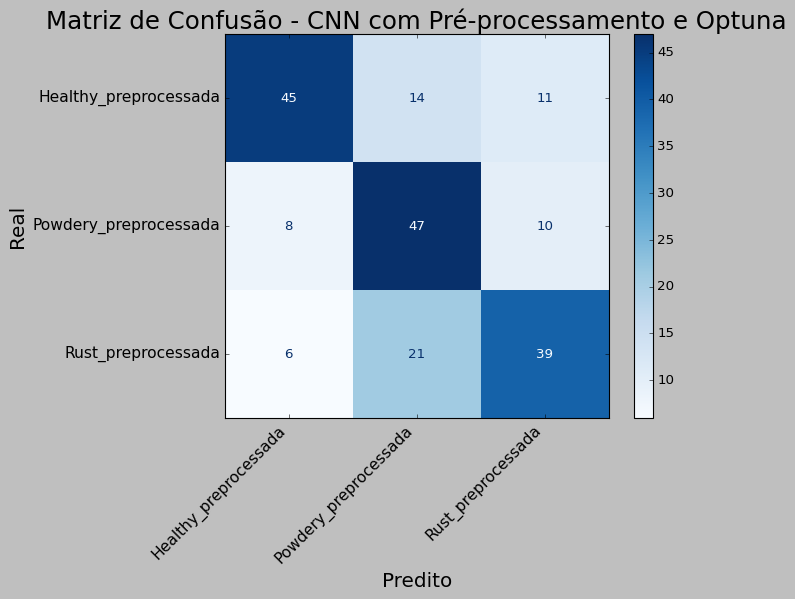

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matriz_confusao = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(
    confusion_matrix=matriz_confusao,
    display_labels=class_names
)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(cmap='Blues', ax=ax)

# 🔹 Aumentar fonte dos ticks (labels nos eixos)
ax.tick_params(axis='both', labelsize=14)

# 🔹 Rotacionar labels do eixo X
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

# 🔹 Aumentar fonte dos labels dos eixos
ax.set_xlabel("Predito", fontsize=18)
ax.set_ylabel("Real", fontsize=18)

# 🔹 Aumentar fonte do título
plt.title("Matriz de Confusão - CNN com Pré-processamento e Optuna", fontsize=22)

plt.show()
